In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linprog


class KNNClassifier:
    """Standard 1-NN Classifier"""
    def __init__(self, k=1):
        self.k = k
        self.nn = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        # Find closest neighbor
        _, idxs = self.nn.kneighbors(X)
        return self.y_train[idxs[:, 0]]

class LocalSimplicialClassifier:
    """
    Hybrid Simplicial Classifier:
    1. Tries to interpolate using Linear Programming (LP).
    2. If point is OUTSIDE hull (LP fails), falls back to 1-NN.
    """
    def __init__(self, k=15):
        self.k = int(k)
        self.nn = None
        self.X_train = None
        self.y_train = None
        self.coverage_rate_ = 0.0

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples, dtype=int)
        success_count = 0
        
        c = np.zeros(self.k)
        bounds = [(0, None) for _ in range(self.k)]
        
        dists, idxs = self.nn.kneighbors(X)
        
        print(f"Solving LP for {n_samples} points...", end="\r")
        
        for i in range(n_samples):
            local_idx = idxs[i]
            X_loc = self.X_train[local_idx]
            y_loc = self.y_train[local_idx]
            
            A_eq = np.vstack([X_loc.T, np.ones((1, self.k))])
            b_eq = np.concatenate([X[i], [1.0]])
            
            res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            
            if res.success:
                w = res.x
                score = np.dot(w, y_loc)
                y_pred[i] = 1 if score >= 0.5 else 0
                success_count += 1
            else:
                y_pred[i] = y_loc[0]
                
        self.coverage_rate_ = success_count / n_samples
        return y_pred

In [2]:
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def make_logistic_gaussian_data(n, d, gamma=2.0, p_noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(0.0, 1.0, size=(n, d))
    
    # Dense teacher vector
    u = rng.normal(0.0, 1.0, size=d)
    u /= np.linalg.norm(u)
    
    eta = sigmoid(gamma * (X @ u))
    y_clean = (rng.random(n) < eta).astype(int)
    
    # Add noise
    y = y_clean.copy()
    flips = rng.random(n) < p_noise
    y[flips] = 1 - y[flips]
    
    return X, y, y_clean



Running Experiment across dimensions [3, 4, 5, 6, 7, 8]...

Processing Dimension d=3 (k=9)...
  Noise 0.00 -> 1NN: 0.569, Simp: 0.594 (Cov: 82.90%)
  Noise 0.05 -> 1NN: 0.563, Simp: 0.589 (Cov: 82.90%)
  Noise 0.10 -> 1NN: 0.566, Simp: 0.590 (Cov: 82.90%)
  Noise 0.20 -> 1NN: 0.552, Simp: 0.564 (Cov: 82.90%)
  Noise 0.30 -> 1NN: 0.540, Simp: 0.547 (Cov: 82.90%)

Processing Dimension d=4 (k=12)...
  Noise 0.00 -> 1NN: 0.561, Simp: 0.557 (Cov: 75.40%)
  Noise 0.05 -> 1NN: 0.570, Simp: 0.558 (Cov: 75.40%)
  Noise 0.10 -> 1NN: 0.560, Simp: 0.545 (Cov: 75.40%)
  Noise 0.20 -> 1NN: 0.558, Simp: 0.544 (Cov: 75.40%)
  Noise 0.30 -> 1NN: 0.549, Simp: 0.518 (Cov: 75.40%)

Processing Dimension d=5 (k=15)...
  Noise 0.00 -> 1NN: 0.557, Simp: 0.570 (Cov: 64.90%)
  Noise 0.05 -> 1NN: 0.557, Simp: 0.582 (Cov: 64.90%)
  Noise 0.10 -> 1NN: 0.556, Simp: 0.591 (Cov: 64.90%)
  Noise 0.20 -> 1NN: 0.549, Simp: 0.565 (Cov: 64.90%)
  Noise 0.30 -> 1NN: 0.532, Simp: 0.532 (Cov: 64.90%)

Processing Dimension d=

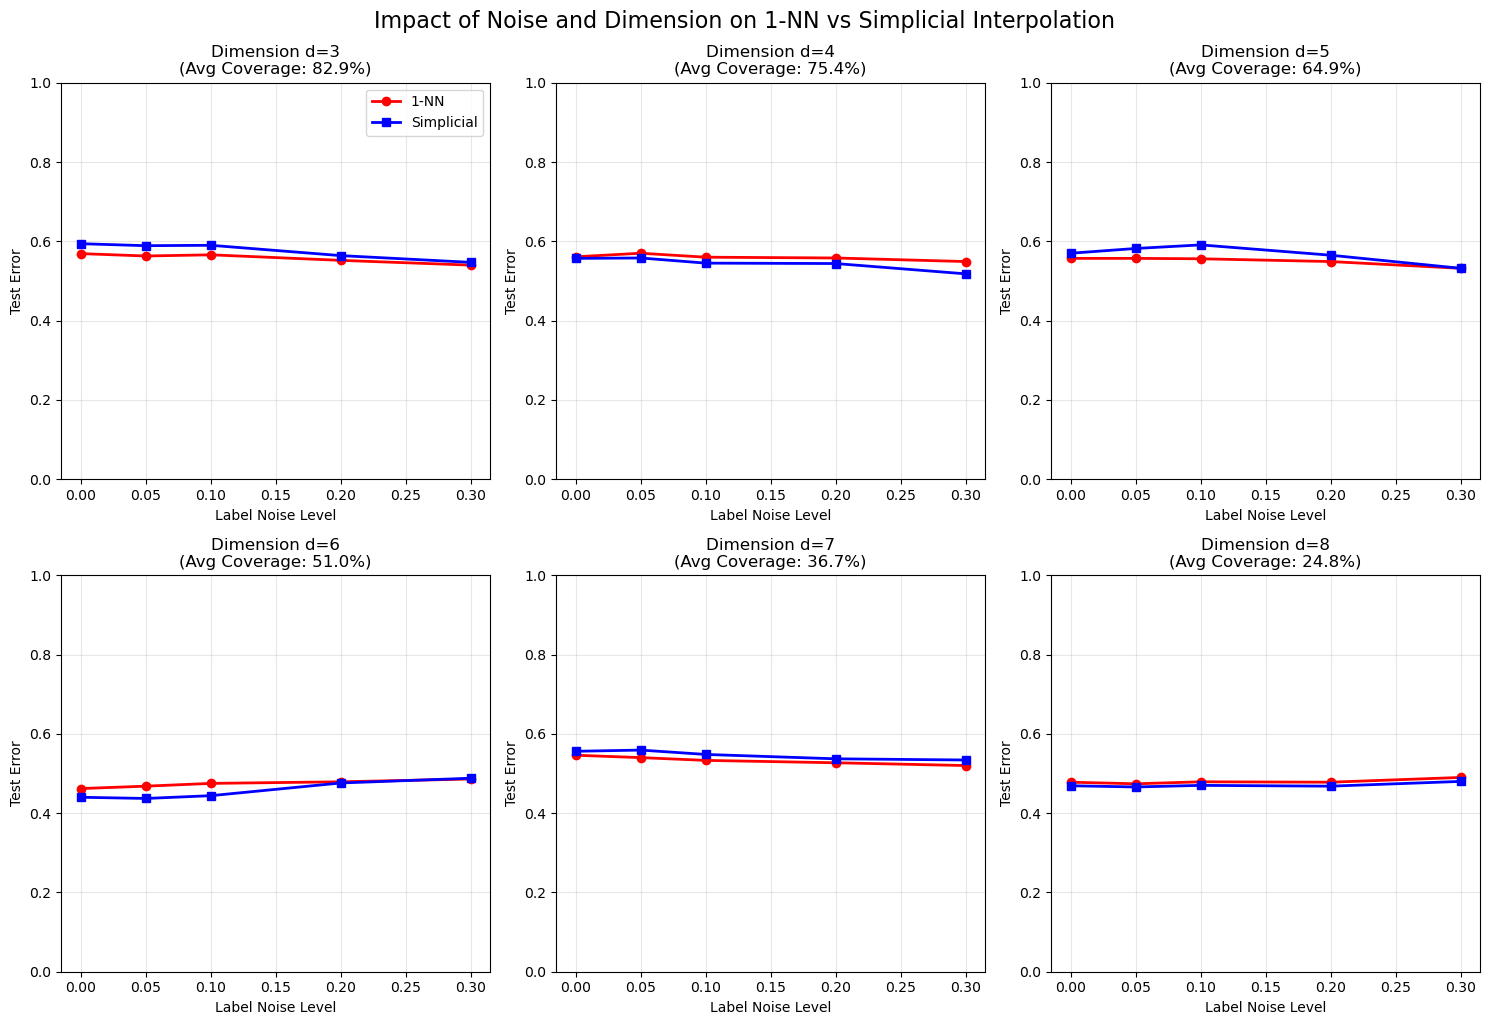

In [6]:
d_values = range(3, 9)  # 3, 4, 5, 6, 7, 8
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = range(5)

n_train = 30000
n_test = 200 # Smaller test set for speed (LP is slow)

# Storage for results
results = {} # structure: results[d] = {noise: (mean_1nn, mean_simp, mean_cov)}

print(f"Running Experiment across dimensions {list(d_values)}...")

for d in d_values:
    results[d] = {'noise': [], '1nn_err': [], 'simp_err': [], 'cov': []}
    
    # Scale k neighbors with dimension to give Simplicial a chance
    k_simplicial = d * 3 
    
    print(f"\nProcessing Dimension d={d} (k={k_simplicial})...")
    
    for noise in noise_levels:
        temp_1nn = []
        temp_simp = []
        temp_cov = []
        
        for s in seeds:
            # Generate Data
            Xtr, ytr, _ = make_logistic_gaussian_data(n_train, d, p_noise=noise, seed=s)
            Xte, _, yte = make_logistic_gaussian_data(n_test, d, p_noise=0.0, seed=s+100)
            
            # 1-NN
            m1 = KNNClassifier(k=1).fit(Xtr, ytr)
            temp_1nn.append(np.mean(m1.predict(Xte) != yte))
            
            # Simplicial
            ms = LocalSimplicialClassifier(k=k_simplicial).fit(Xtr, ytr)
            temp_simp.append(np.mean(ms.predict(Xte) != yte))
            temp_cov.append(ms.coverage_rate_)
            
        # Store aggregated results
        results[d]['noise'].append(noise)
        results[d]['1nn_err'].append(np.mean(temp_1nn))
        results[d]['simp_err'].append(np.mean(temp_simp))
        results[d]['cov'].append(np.mean(temp_cov))
        
        print(f"  Noise {noise:.2f} -> 1NN: {np.mean(temp_1nn):.3f}, Simp: {np.mean(temp_simp):.3f} (Cov: {np.mean(temp_cov):.2%})")

# ==========================================
# PLOTTING
# ==========================================


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = results[d]
    
    # Plot Error Lines
    ax.plot(data['noise'], data['1nn_err'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['simp_err'], 'b-s', label='Simplicial', linewidth=2)
    
    # Add title with average coverage info (to explain performance)
    avg_coverage = np.mean(data['cov'])
    ax.set_title(f"Dimension d={d}\n(Avg Coverage: {avg_coverage:.1%})")
    
    ax.set_xlabel("Label Noise Level")
    ax.set_ylabel("Test Error")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    if i == 0: # Only legend on first plot
        ax.legend()

plt.tight_layout()
plt.suptitle("Impact of Noise and Dimension on 1-NN vs Simplicial Interpolation", y=1.02, fontsize=16)
plt.show()